In [70]:
FRAME_SIZE = 150
HOP_RATIO = 0.1
N_FFT = 1024
VIGILANCE = 0.5
BUFFER_SIZE = 5

In [ ]:
from modules.AudioProcessor import AudioProcessor

audio_files = [
    './dataset/trimmed_crowd_talking.mp3',
    './dataset/trimmed_motor_riding.mp3',
    './dataset/trimmed_water_flowing.mp3'
]
ap = AudioProcessor(
    audio_files, 
    frame_size_ms=FRAME_SIZE, 
    hop_length_ratio=HOP_RATIO
    )
print(ap.frames.shape)
print(ap.class_ids.shape)
print(ap.timestamps.shape)

torch.Size([23973, 7200])
(23973,)
(23973,)


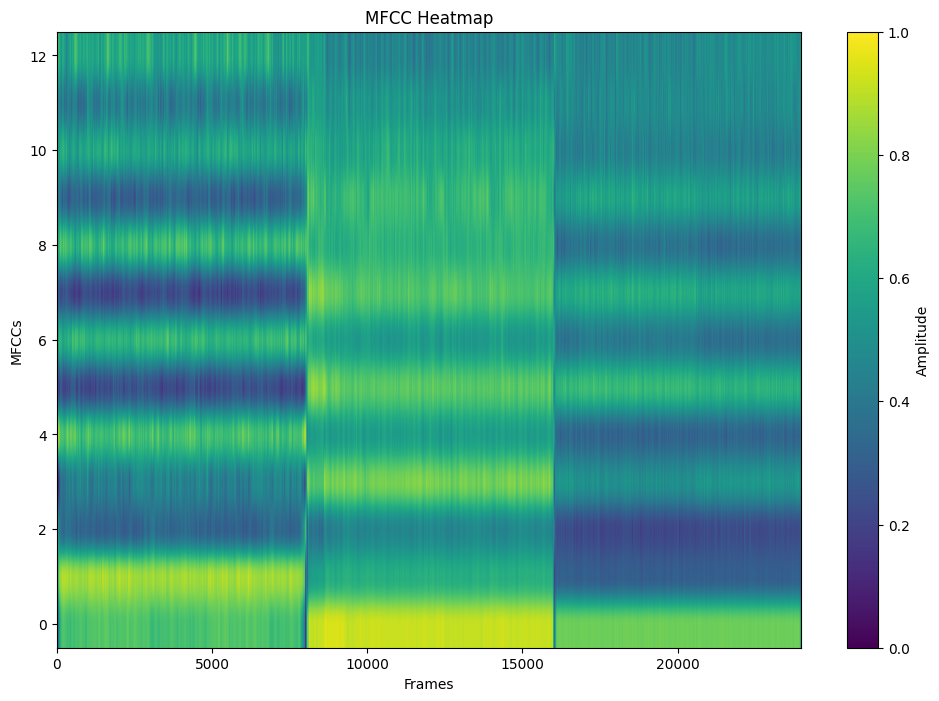

torch.Size([23973, 13])

In [ ]:
from modules.FeatureExtractor import FeatureExtractor

fe = FeatureExtractor(n_fft=N_FFT)
fe.extract_mfcc(ap.frames)
fe.plot_mfccs()
fe.mfcc_features.shape

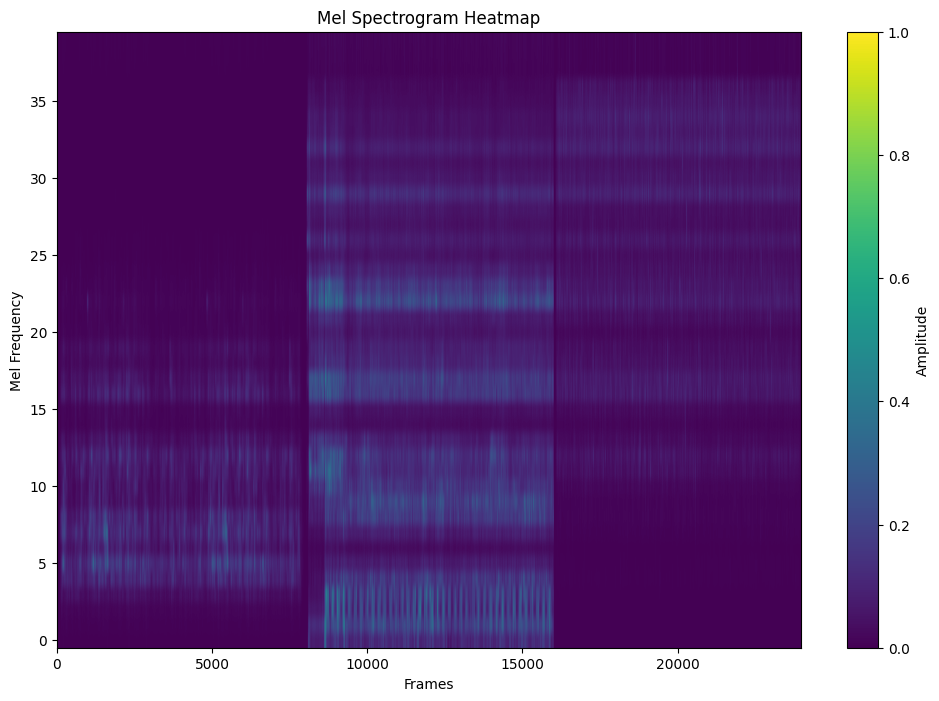

torch.Size([23973, 40])

In [65]:
fe.extract_melspectrogram(ap.frames)
fe.plot_melspectrogram()
fe.melspectrogram_features.shape

In [ ]:
important_mfcc_features = [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11]
important_mfsc_features = [i for i in range(14)] + [i for i in range(16, 35)]

from modules.DatasetHandler import DatasetHandler

dh = DatasetHandler(
    ap.class_ids,
    ap.timestamps, 
    fe.mfcc_features, 
    fe.melspectrogram_features, 
    len(important_mfcc_features) + len(important_mfsc_features)
)
dh.generate_csv()
dh.save_selected_features(important_mfcc_features, important_mfsc_features)

time_series_tensor = dh.generate_time_series(FRAME_SIZE, HOP_RATIO)
time_series_tensor.shape

torch.Size([5, 8000, 44])

Clustering samples for time series 0
Clustering completed
Confusion matrix:
[[2686    0    0]
 [2672    0    0]
 [2642    0    0]]


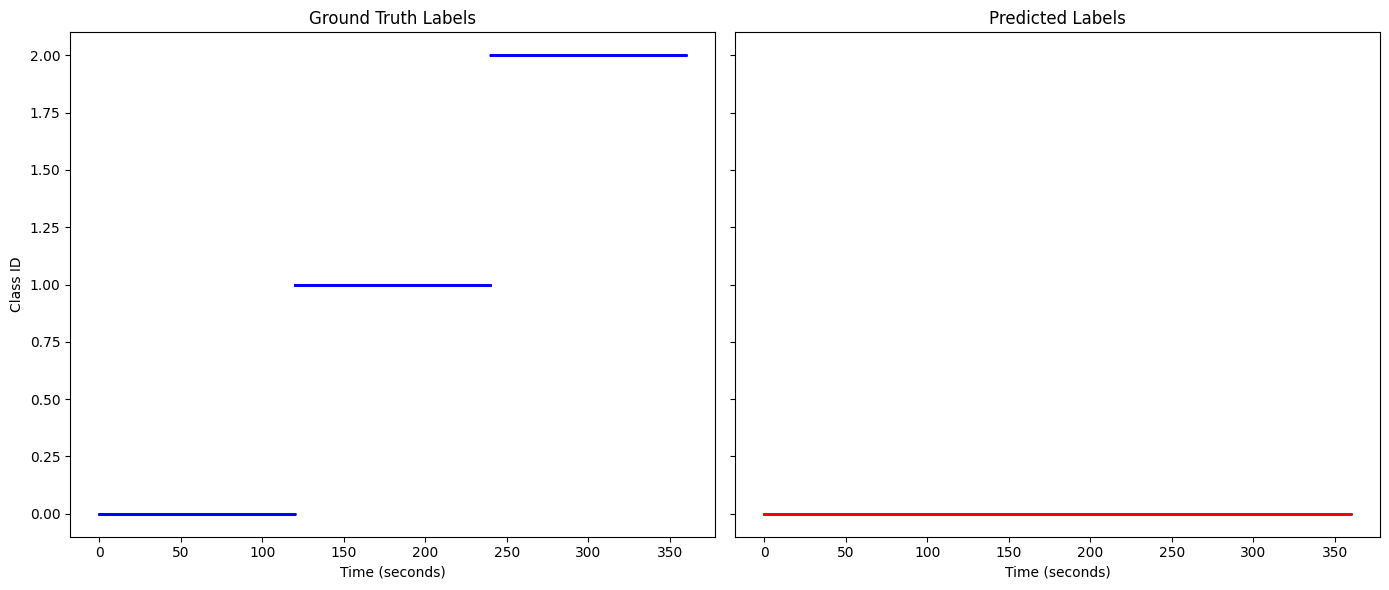

Accuracy: 33.575%

Clustering samples for time series 1
Clustering completed
Confusion matrix:
[[ 450    0 2209]
 [ 125    0 2524]
 [ 120    0 2572]]


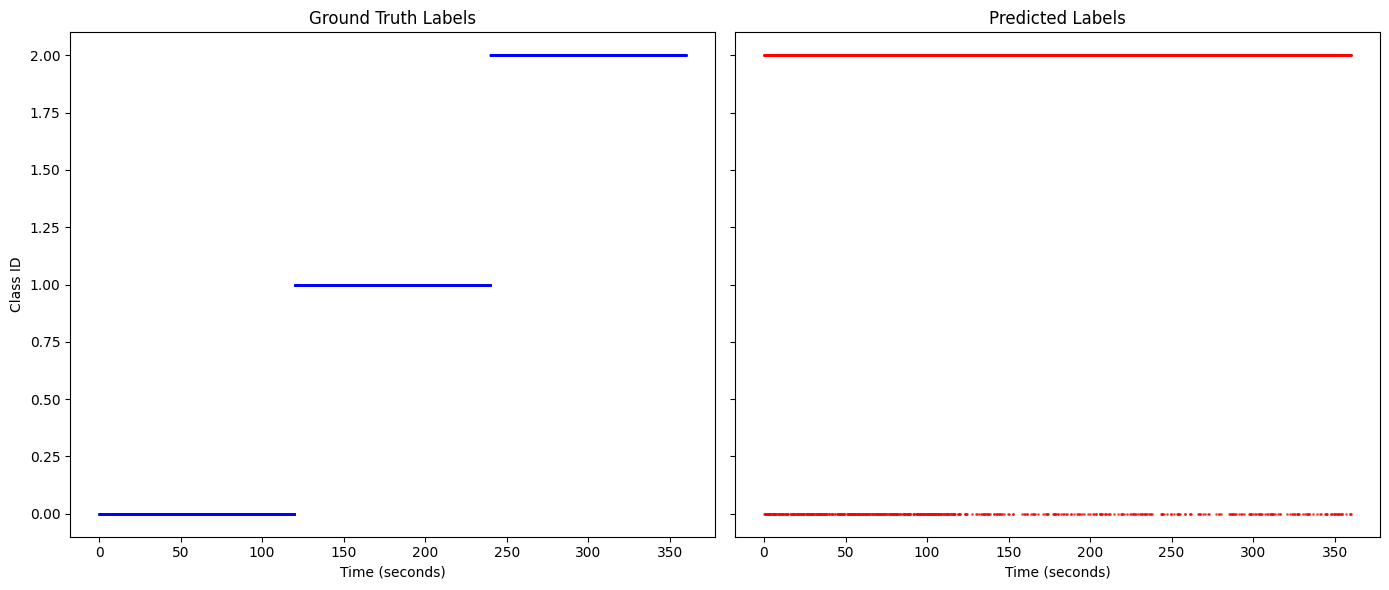

Accuracy: 37.775%

Clustering samples for time series 2
Clustering completed
Confusion matrix:
[[   0 2697    0]
 [   0 2718    0]
 [   0 2585    0]]


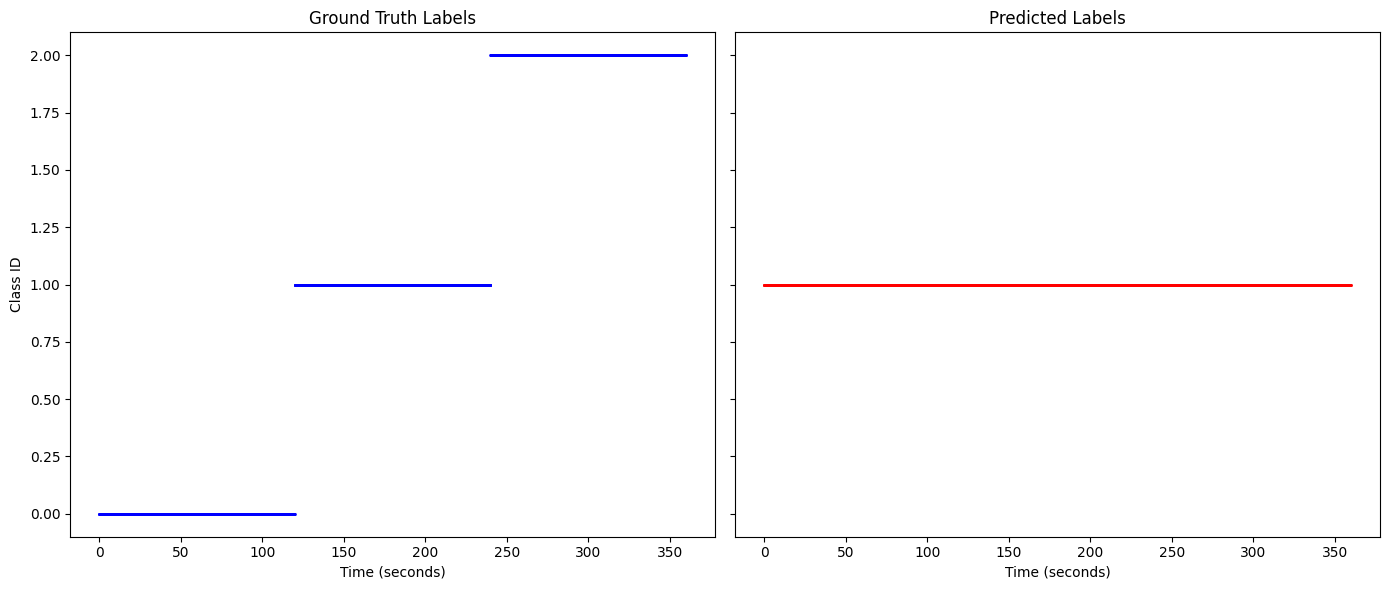

Accuracy: 33.975%

Clustering samples for time series 3
Clustering completed
Confusion matrix:
[[2489  149    0]
 [2109  589    0]
 [2447  217    0]]


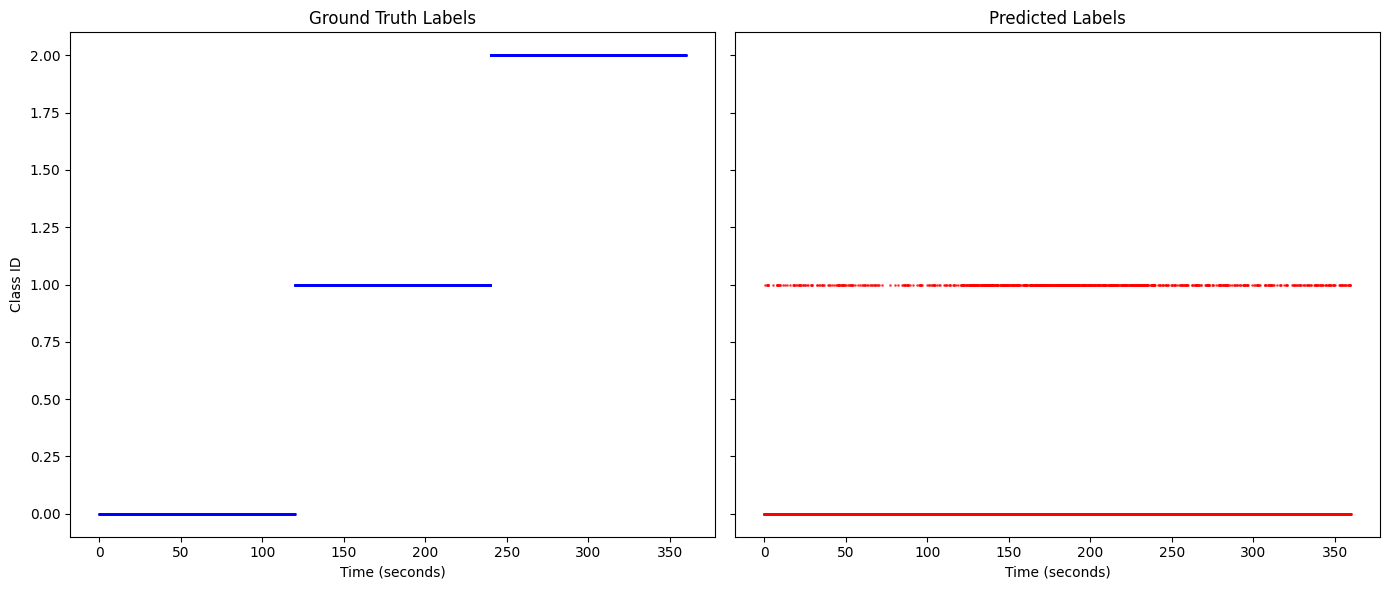

Accuracy: 38.475%

Clustering samples for time series 4
Clustering completed
Confusion matrix:
[[ 638 2001    0]
 [ 183 2560    0]
 [ 184 2434    0]]


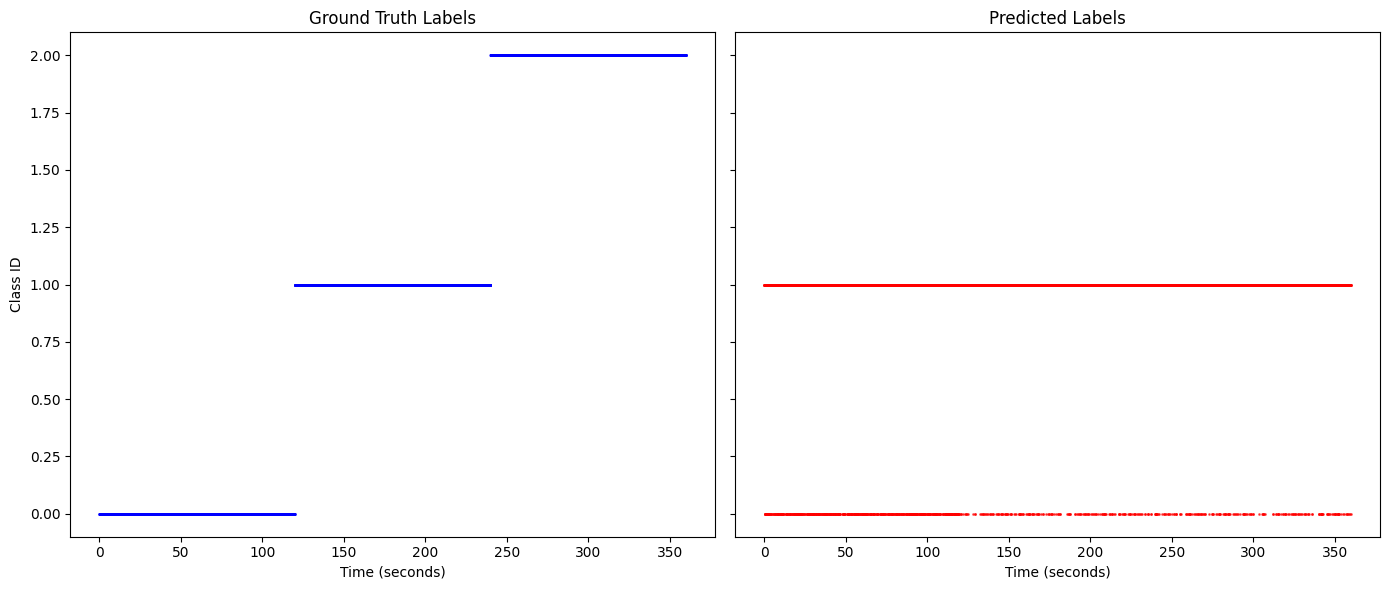

Accuracy: 39.975%



In [ ]:
from modules.ART2Clusterer import SmoothingART2Clusterer

for i in range(len(time_series_tensor)):
    clusterer = SmoothingART2Clusterer(
        vigilance=VIGILANCE, 
        n_features=time_series_tensor.shape[2],
        n_clusters=20,
        max_samples_per_cluster=time_series_tensor.shape[1]+1,
        buffer_size=BUFFER_SIZE
    )
    print(f"Clustering samples for time series {i}")
    for j, sample in enumerate(time_series_tensor[i]):
        clusterer.fit_clusters(sample, j)
    print("Clustering completed")
    confusion_matrix = clusterer.calc_confusion_matrix(f'./output/ground_truth_{i}.csv')
    print(f"Confusion matrix:\n{confusion_matrix}")
    clusterer.plot_truth_vs_time(f'./output/ground_truth_{i}.csv')
    accuracy = clusterer.calc_accuracy(confusion_matrix)
    print(f"Accuracy: {accuracy*100}%\n")